In [10]:
import sys
sys.path.append('../scripts')
import pandas as pd
import proplot as pplt
import matplotlib as mpl
import os
from helpers import *
import xarray as xr
import numpy as np

def print(*val):
    display(*val)

In [207]:
%run ../scripts/process_stations.py

In [217]:
station_metadata().loc[station_metadata().idxmax()["# Days"]]

sensor_id         2019P124
Deployment Leg           1
# Days                 603
Name: P040, dtype: object

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


<a list of 1 Line2D objects>

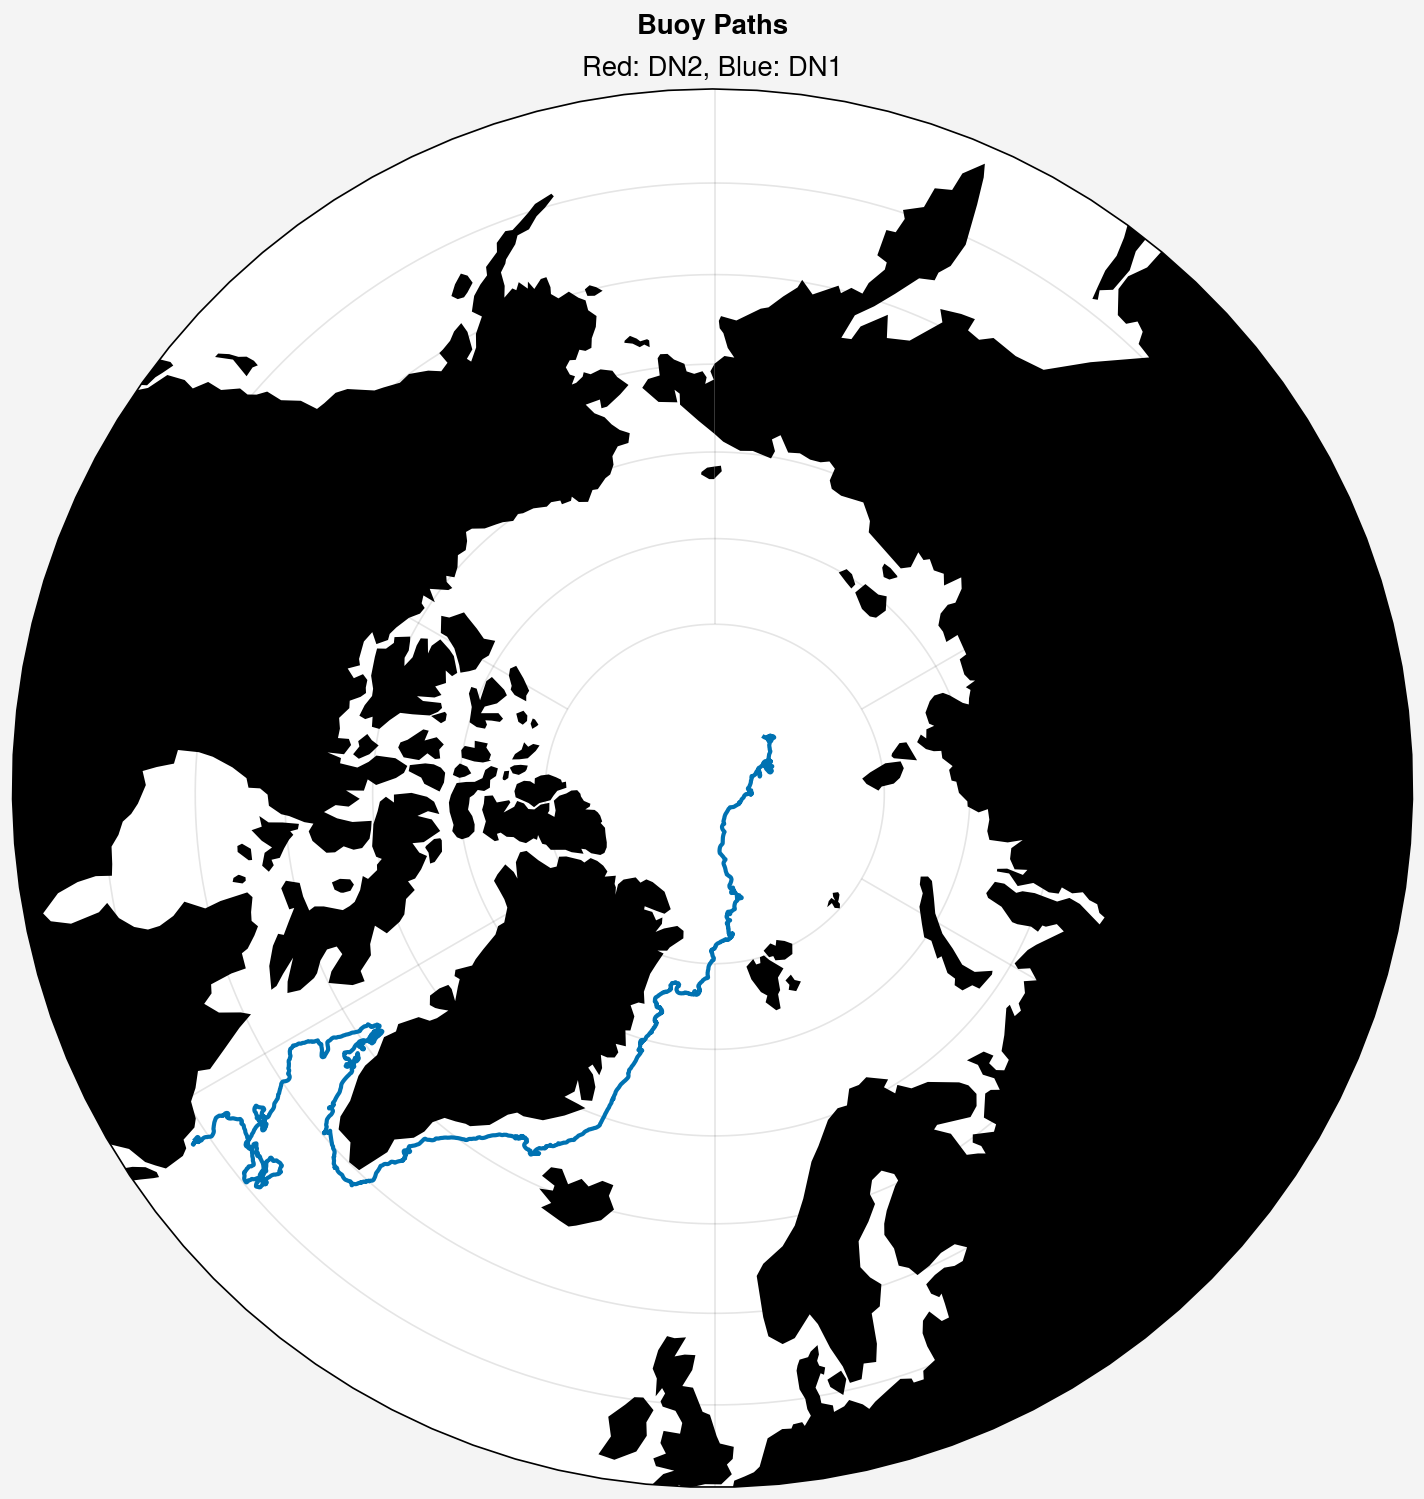

In [219]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/daily_stations/mosaic_dn1")
dn2 = os.listdir("../data/daily_stations/mosaic_dn2")

axs[0].format(boundinglat=50, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue

#for station in [i[:-4] for i in dn1]:
#    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="blue")
#for station in [i[:-4] for i in dn2]:
#    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="red")

axs[0].plot(buoy_data("2019P124")['longitude'], buoy_data("2019P124")["latitude"])

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


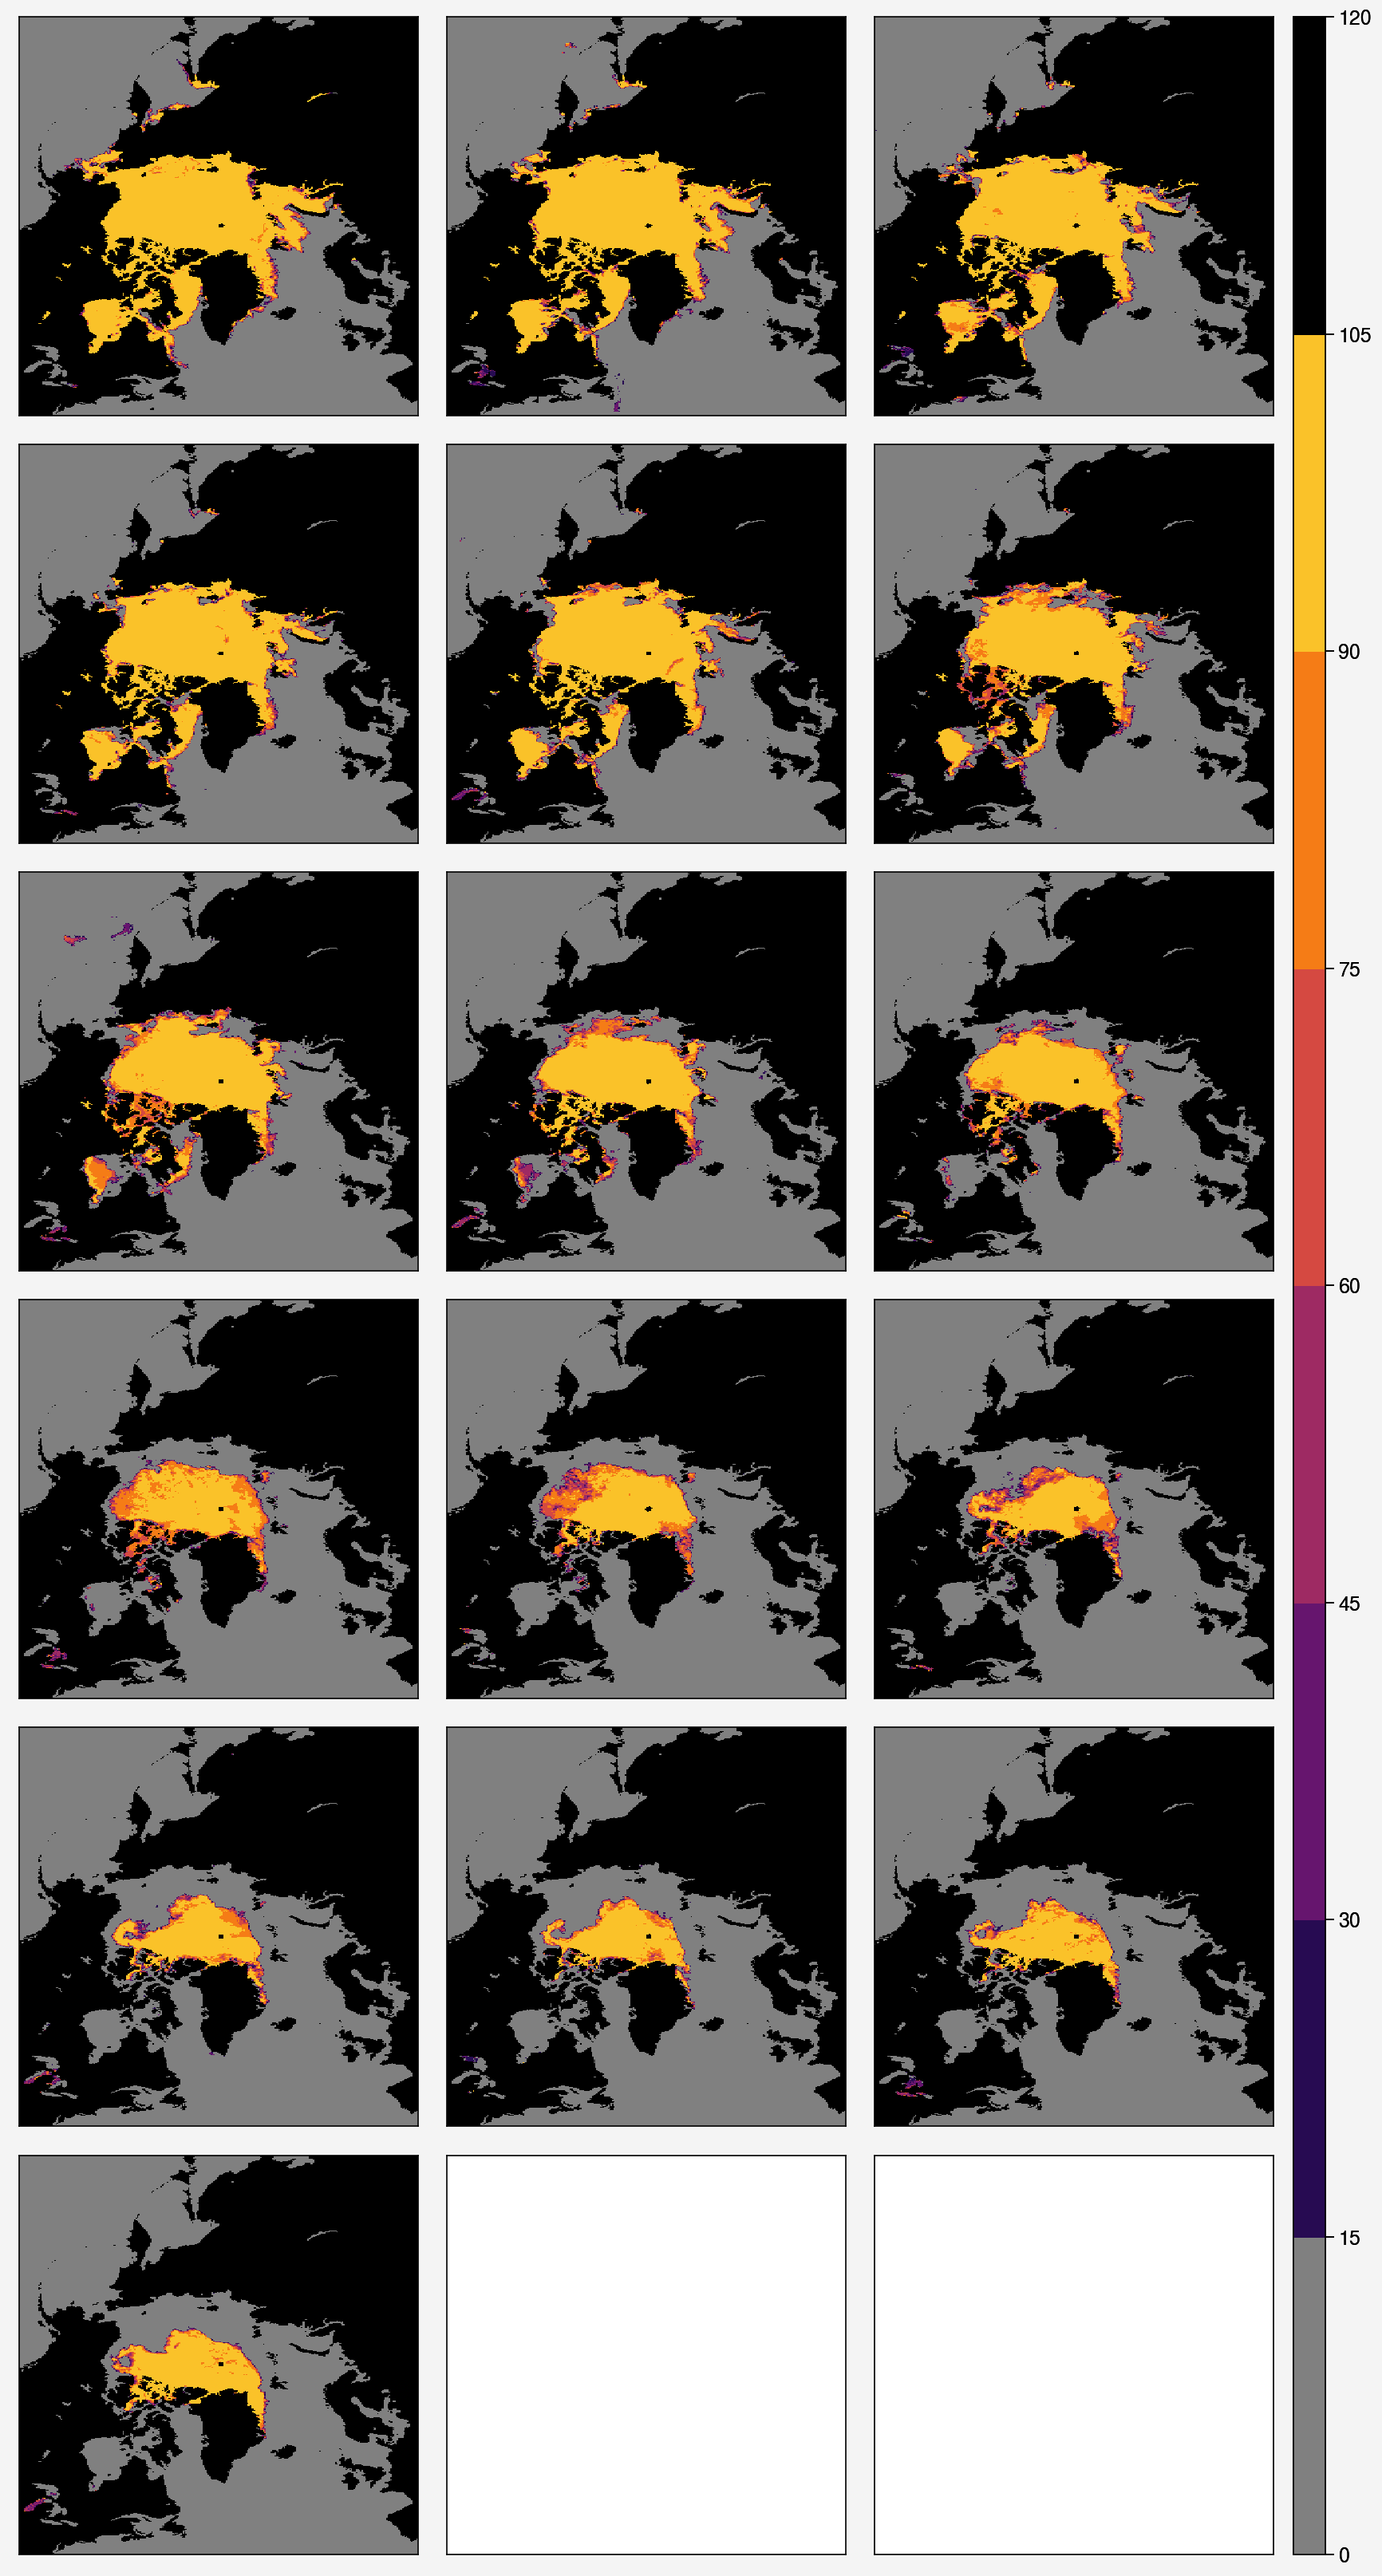

In [128]:
sic_data = xr.open_dataset("../data/sea_ice_concentration/amsr2_sea_ice_concentration.nc")
data = sic_data["sea_ice_concentration"].values

fig = pplt.figure()

cmap = pplt.Colormap('inferno')

newcolors = cmap(np.linspace(0, 1, 120))
newcolors[:15] = np.array([0.5,0.5,0.5,1])
newcolors[109:] = np.array([0,0,0,1])


n = 16
dt = 10

ax = fig.subplots(nrows=(n+2)//3, ncols=3)

for i in range(n):
    snapshot = np.rot90(data[dt*i].T)
    h = ax[i].pcolormesh(snapshot, cmap=newcolors)

fig.colorbar(h, loc='r')
ax.format(xlocator='null', ylocator='null')

# Last Day in Ice

In [41]:
times = sic_data["time"].values


concentrations = sic_data.isel(x=0,y=0)["sea_ice_concentration"].values
np.argmax(concentrations <= 15)

0

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:


<a list of 1 Line2D objects>

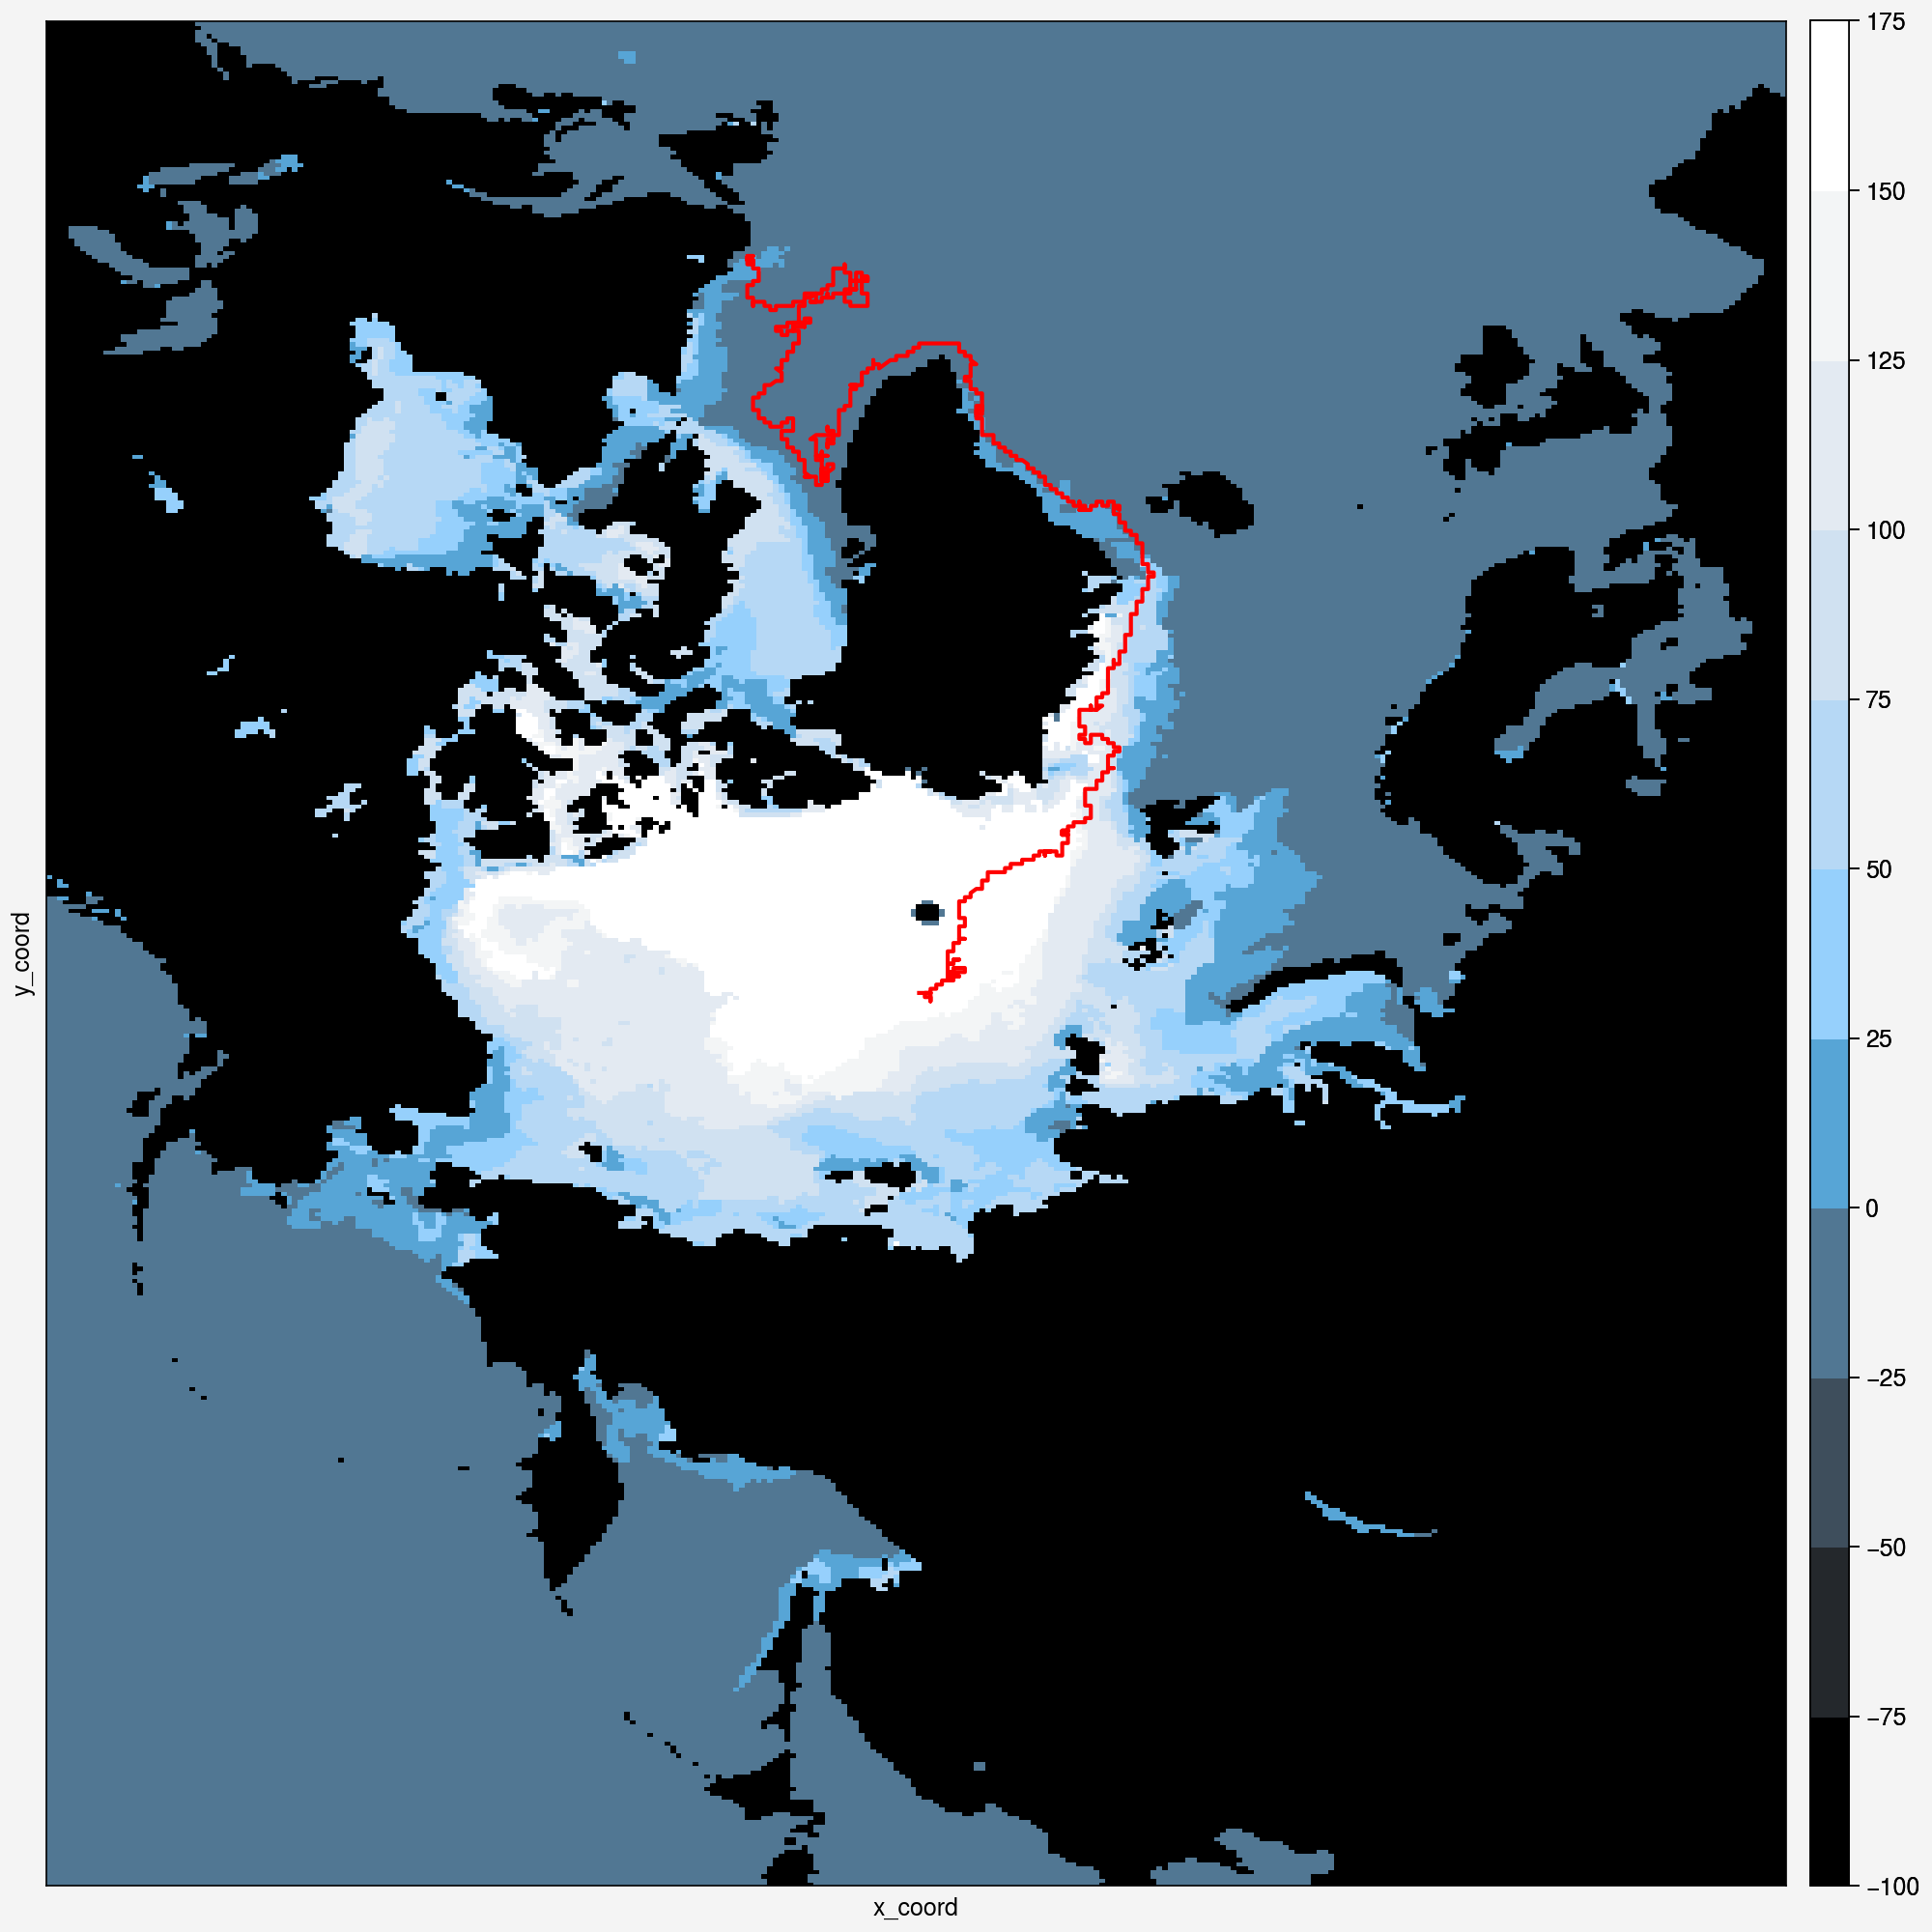

In [221]:
fig, ax = pplt.subplots(figsize=(10,10))
sic = sic_data["sea_ice_concentration"]

water_indicator = sic <= 15
ice_indicator = np.logical_and(sic > 15, sic <= 100)
other_indicator = sic > 100

always_ice = ice_indicator.all(dim="time")
always_other = other_indicator.all(dim="time")

first_water = water_indicator.argmax(dim="time").values
first_water[always_ice] = len(times) - 1
first_water[always_other] = -100

snapshot = np.rot90(first_water.T)
snapshot = first_water

mesh = ax.pcolormesh(snapshot, cmap=["black","light blue","white"])

fig.colorbar(mesh, loc='r')
ax.format(xlocator='null', ylocator='null')


test_data = buoy_data("2019P124").set_index("datetime")[["x_stere","y_stere"]]

xvals = sic_data['x'].values
yvals = sic_data['y'].values

differenced_x = np.abs(np.array(test_data["x_stere"])[:, np.newaxis] - xvals[np.newaxis, :])
differenced_y = np.abs(np.array(test_data["y_stere"])[:, np.newaxis] - yvals[np.newaxis, :])

test_data["x_coord"] = differenced_x.argmin(axis=1)
test_data["y_coord"] = differenced_y.argmin(axis=1)

coords = test_data[["x_coord", "y_coord"]]
ax.line(test_data["x_coord"], test_data["y_coord"], color="red")

In [129]:
first_nonice = first_water
first_nonice[always_other] = 0

first_time = times[first_nonice]

np.save("../data/sea_ice_concentration/first_nonice.npy", first_time)

In [134]:
metadata = buoy_metadata()
metadata[metadata["Interp"] == True]

,datetime,x_stere,y_stere,data_gap_minutes,longitude,latitude
0,2019-10-05 12:00:00,21726.74548,539674.60659,90.0,132.69458,85.01709
1,2019-10-05 15:00:00,21767.25226,538963.01949,180.0,132.68724,85.02363
2,2019-10-05 18:00:00,21527.66755,538530.59360,180.0,132.71083,85.02770
3,2019-10-05 21:00:00,21481.96667,538454.52945,180.0,132.71536,85.02842
4,2019-10-06 00:00:00,21428.08729,538389.88834,180.0,132.72081,85.02903
...,...,...,...,...,...,...
1206,2020-03-15 03:00:00,293936.80725,-151608.00432,180.0,17.71602,86.94761
1207,2020-03-15 06:00:00,294101.73759,-152823.87722,180.0,17.54229,86.94110
1208,2020-03-15 09:00:00,294286.16655,-155022.74364,180.0,17.22084,86.93019
1209,2020-03-15 12:00:00,294394.85160,-158475.62485,180.0,16.70599,86.91433
